In [16]:
from ctypes import *
import time
from sys import path
import sys
from os import sep
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

if sys.platform.startswith("win"):
    dwf = cdll.dwf
    constants_path = "C:" + sep + "Program Files (x86)" + sep + "Digilent" + sep + "WaveFormsSDK" + sep + "samples" + sep + "py"
elif sys.platform.startswith("darwin"):
    dwf = cdll.LoadLibrary("/Library/Frameworks/dwf.framework/dwf")
    constants_path = "/Applications/WaveForms.app/Contents/Resources/SDK/samples/py"
else:
    dwf = cdll.LoadLibrary("libdwf.so")
    constants_path = "/usr/share/digilent/waveforms/samples/py"

path.append(constants_path)
import dwfconstants as constants

In [2]:
dwf.FDwfDeviceCloseAll()
filter_flags = c_int(constants.enumfilterType.value | constants.enumfilterUSB.value)
device_count = c_int()
dwf.FDwfEnum(filter_flags, byref(device_count))

hdwf = c_int()
dwf.FDwfDeviceOpen(c_int(-1), byref(hdwf))
if hdwf.value == 0:
    raise RuntimeError("Failed to open device.")
print(hdwf.value)

dwf.FDwfAnalogIOReset(hdwf)
dwf.FDwfAnalogIOChannelNodeSet(hdwf, c_int(0), c_int(1), c_double(3.0))
dwf.FDwfAnalogIOChannelNodeSet(hdwf, c_int(0), c_int(0), c_double(1))
dwf.FDwfAnalogIOEnableSet(hdwf, c_int(1))
time.sleep(0.5)

vpos = c_double()
dwf.FDwfAnalogIOStatus(hdwf)
dwf.FDwfAnalogIOChannelNodeStatus(hdwf, c_int(0), c_int(1), byref(vpos))
print(f"Power: +{vpos.value:.2f}V")

1
Power: +3.01V


In [3]:
DEVICE_ADDR = 0x52
ENABLE_REG = 0x80
ATIME_REG = 0x81
WTIME_REG = 0x83
CONTROL_REG = 0x8F
CDATAL_REG = 0x94
CDATAH_REG = 0x95
RDATAL_REG = 0x96
RDATAH_REG = 0x97
GDATAL_REG = 0x98
GDATAH_REG = 0x99
BDATAL_REG = 0x9A
BDATAH_REG = 0x9B

def write_register(reg, value):
    iNak = c_int()
    rgTX = (c_ubyte * 2)(reg, value)
    dwf.FDwfDigitalI2cWrite(hdwf, c_int(DEVICE_ADDR), rgTX, c_int(2), byref(iNak))
    return iNak.value == 0

def read_register(reg):
    iNak = c_int()
    rgTX = (c_ubyte * 1)(reg)
    dwf.FDwfDigitalI2cWrite(hdwf, c_int(DEVICE_ADDR), rgTX, c_int(1), byref(iNak))
    if iNak.value == 0:
        rgRX = (c_ubyte * 1)()
        dwf.FDwfDigitalI2cRead(hdwf, c_int(DEVICE_ADDR), rgRX, c_int(1), byref(iNak))
        if iNak.value == 0:
            return rgRX[0]
    return None

dwf.FDwfDigitalI2cRateSet(hdwf, c_double(100e3))
dwf.FDwfDigitalI2cSclSet(hdwf, c_int(0))
dwf.FDwfDigitalI2cSdaSet(hdwf, c_int(1))
iNak = c_int()
dwf.FDwfDigitalI2cClear(hdwf, byref(iNak))

1

In [4]:
write_register(ENABLE_REG, 0x01)
time.sleep(0.01)
write_register(ENABLE_REG, 0x0B)
write_register(ATIME_REG, 0xFF)
write_register(CONTROL_REG, 0x02)

def read_colors():
    time.sleep(0.1)
    
    clear_low = read_register(CDATAL_REG)
    clear_high = read_register(CDATAH_REG)
    red_low = read_register(RDATAL_REG)
    red_high = read_register(RDATAH_REG)
    green_low = read_register(GDATAL_REG)
    green_high = read_register(GDATAH_REG)
    blue_low = read_register(BDATAL_REG)
    blue_high = read_register(BDATAH_REG)
    
    if all(val is not None for val in [clear_low, clear_high, red_low, red_high, green_low, green_high, blue_low, blue_high]):
        clear = (clear_high << 8) | clear_low
        red = (red_high << 8) | red_low
        green = (green_high << 8) | green_low
        blue = (blue_high << 8) | blue_low
        return {'clear': clear, 'red': red, 'green': green, 'blue': blue}
    return None

In [ ]:
data1={'clear': [], 'red': [], 'green': [], 'blue': []}

write_register(WTIME_REG, 0xFF) # Wait Time value FF
write_register(ATIME_REG, 0xB0) # Integration Time value FF

for i in range(256):
    write_register(WTIME_REG, 255 - i) # Varying Wait Time value
    colors = read_colors()
    data1['clear'].append(colors['clear'])
    data1['red'].append(colors['red'])
    data1['green'].append(colors['green'])
    data1['blue'].append(colors['blue'])
    print(f"Index {i}: {colors['clear']}, R: {colors['red']}, G: {colors['green']}, B: {colors['blue']}")

Index 0: 6, R: 1, G: 2, B: 2
Index 1: 6, R: 1, G: 2, B: 2
Index 2: 6, R: 1, G: 2, B: 2
Index 3: 6, R: 1, G: 173, B: 166
Index 4: 486, R: 112, G: 173, B: 166
Index 5: 483, R: 111, G: 173, B: 165
Index 6: 483, R: 111, G: 173, B: 165
Index 7: 485, R: 111, G: 173, B: 165
Index 8: 485, R: 111, G: 173, B: 165
Index 9: 485, R: 111, G: 173, B: 166
Index 10: 486, R: 111, G: 173, B: 166
Index 11: 485, R: 111, G: 173, B: 165
Index 12: 485, R: 111, G: 173, B: 165
Index 13: 485, R: 111, G: 173, B: 165
Index 14: 485, R: 111, G: 173, B: 165
Index 15: 485, R: 111, G: 173, B: 165
Index 16: 484, R: 111, G: 173, B: 165
Index 17: 484, R: 111, G: 173, B: 165
Index 18: 486, R: 111, G: 173, B: 166
Index 19: 486, R: 111, G: 172, B: 165
Index 20: 483, R: 111, G: 172, B: 165
Index 21: 485, R: 111, G: 173, B: 166
Index 22: 485, R: 111, G: 173, B: 166
Index 23: 486, R: 112, G: 173, B: 166
Index 24: 486, R: 112, G: 173, B: 166
Index 25: 482, R: 111, G: 172, B: 164
Index 26: 482, R: 111, G: 172, B: 164
Index 27: 48

In [18]:
df = pd.DataFrame(data1, columns=['clear', 'red', 'green', 'blue'])
print(df)

     clear  red  green  blue
0        6    1      2     2
1        6    1      2     2
2        6    1      2     2
3        6    1    173   166
4      486  112    173   166
..     ...  ...    ...   ...
251    482  110    172   164
252    482  110    172   164
253    482  110    172   164
254    482  110    172   164
255    482  110    172   164

[256 rows x 4 columns]


In [17]:
stdevc = np.std(data1['clear'])
stdevr = np.std(data1['red'])
stdevg = np.std(data1['green'])
stdevb = np.std(data1['blue'])

print(f"Standard Deviation - Clear: {stdevc}, Red: {stdevr}, Green: {stdevg}, Blue: {stdevb}")


Standard Deviation - Clear: 59.245375440690715, Red: 13.627936090613419, Green: 18.363184029736264, Blue: 17.524783215018623


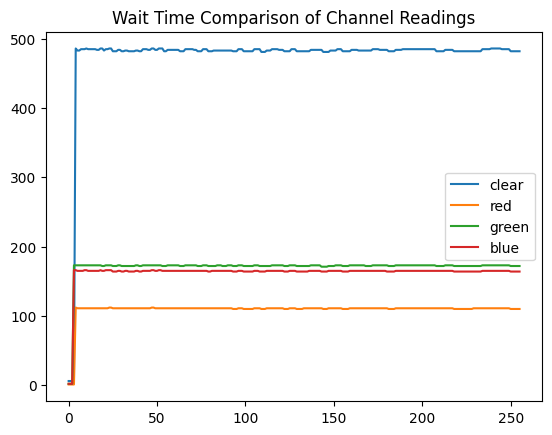

In [19]:
fig, ax = plt.subplots()

# Plot each DataFrame on the same axes

df['clear'].plot(ax=ax, label='clear')
df['red'].plot(ax=ax, label='red')
df['green'].plot(ax=ax, label='green')
df['blue'].plot(ax=ax, label='blue')


# Add legend and display

plt.title('Wait Time Comparison of Channel Readings')
plt.legend()
#plt.figure(figsize=(40,15))
plt.show()

In [20]:
def cleanup():
    dwf.FDwfDeviceClose(hdwf)
cleanup()